In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

# Define the path to your MLassignment3 folder
path_to_ml_assignment = '/content/drive/MyDrive/MLassignment3'

# Check if the directory exists
if os.path.exists(path_to_ml_assignment):
    # List all files and directories in the specified path
    files_in_folder = os.listdir(path_to_ml_assignment)
    print(f"Files in '{path_to_ml_assignment}':")
    for item in files_in_folder:
        print(item)
else:
    print(f"Error: The directory '{path_to_ml_assignment}' does not exist. Please check the path and ensure your Google Drive is mounted correctly.")

Files in '/content/drive/MyDrive/MLassignment3':
sample_submission.csv
test.csv
train.csv
train
test


In [3]:
# Define the paths to the train and test folders
path_to_train_folder = os.path.join(path_to_ml_assignment, 'train')
path_to_test_folder = os.path.join(path_to_ml_assignment, 'test')

# Function to list files in a directory
def list_files_in_directory(directory_path):
    if os.path.exists(directory_path):
        print(f"\nFiles in '{directory_path}':")
        files = os.listdir(directory_path)
        # Print only the first few files to avoid overwhelming output
        for i, item in enumerate(files):
            if i < 10: # Displaying up to 10 files
                print(item)
            else:
                print(f"... and {len(files) - 10} more files.")
                break
        if not files:
            print("No files found.")
    else:
        print(f"Error: The directory '{directory_path}' does not exist.")

# List files in the train folder
list_files_in_directory(path_to_train_folder)

# List files in the test folder
list_files_in_directory(path_to_test_folder)


Files in '/content/drive/MyDrive/MLassignment3/train':
train

Files in '/content/drive/MyDrive/MLassignment3/test':
test


In [4]:
import os

# Correct the path to the actual image directory within the train folder
path_to_nested_train_images = os.path.join(path_to_train_folder, 'train')

# List files in the corrected train image folder
def list_files_in_directory_full(directory_path):
    if os.path.exists(directory_path):
        print(f"\nFiles in '{directory_path}':")
        files = os.listdir(directory_path)
        if files:
            for i, item in enumerate(files):
                if i < 10: # Displaying up to 10 files
                    print(item)
                else:
                    print(f"... and {len(files) - 10} more files.")
                    break
        else:
            print("No files found.")
    else:
        print(f"Error: The directory '{directory_path}' does not exist. Please check the path.")

list_files_in_directory_full(path_to_nested_train_images)


Files in '/content/drive/MyDrive/MLassignment3/train/train':
vqh.jpg
vbp.jpg
vxk.jpg
vxm.jpg
vju.jpg
vtf.jpg
vml.jpg
vdf.jpg
vsg.jpg
vma.jpg
... and 5301 more files.


In [5]:
import pandas as pd
import os

# Define the path to your MLassignment3 folder (assuming it's already mounted)
path_to_ml_assignment = '/content/drive/MyDrive/MLassignment3'

# Define the path to train.csv
train_csv_path = os.path.join(path_to_ml_assignment, 'train.csv')

# Load the train.csv file
try:
    train_df = pd.read_csv(train_csv_path)
    print(f"'{train_csv_path}' file successfully loaded.")
    # Display the first few rows of the DataFrame
    print("\nDataFrame head:")
    display(train_df.head())

    # Display basic information about the DataFrame
    print("\nDataFrame info:")
    train_df.info()
except FileNotFoundError:
    print(f"Error: '{train_csv_path}' not found. Please check the path.")
except Exception as e:
    print(f"Error occurred while loading the file: {e}")

'/content/drive/MyDrive/MLassignment3/train.csv' file successfully loaded.

DataFrame head:


,id,artist
0,dxi,Diego Velazquez
1,lxu,Vincent van Gogh
2,edc,Claude Monet
3,bis,Edgar Degas
4,jly,Hieronymus Bosch



DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5311 entries, 0 to 5310
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      5311 non-null   object
 1   artist  5311 non-null   object
dtypes: object(2)
memory usage: 83.1+ KB


In [6]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from collections import Counter

path_to_ml_assignment = '/content/drive/MyDrive/MLassignment3'
path_to_nested_train_images = os.path.join(path_to_ml_assignment, 'train', 'train')
path_to_nested_test_images = os.path.join(path_to_ml_assignment, 'test', 'test')

In [7]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import pandas as pd

# Define a custom Dataset class to handle image loading and labeling from a DataFrame
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.img_labels = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.has_labels = 'artist' in dataframe.columns # Check if 'artist' column exists

        if self.has_labels:
            # For train data, create a mapping from artist names (labels) to integer indices
            self.classes = sorted(self.img_labels['artist'].unique())
            self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        else:
            # For test data without 'artist' column, we don't have true classes here
            # We might populate self.classes from the train_dataset if needed for model output layer size
            self.classes = [] # Placeholder
            self.class_to_idx = {} # Placeholder

        # Prepare a list of (image_full_path, label_index) tuples
        self.samples = []
        for idx, row in self.img_labels.iterrows():
            img_name = row['id'] + '.jpg' # Assuming image IDs map to .jpg files
            img_path = os.path.join(self.img_dir, img_name)

            if os.path.exists(img_path):
                label_idx = -1 # Use -1 or a specific dummy value for test set if no labels
                if self.has_labels:
                    label_name = row['artist']
                    label_idx = self.class_to_idx[label_name]
                self.samples.append((img_path, label_idx))
            # else:
            #     print(f"Warning: Image file not found: {img_path}") # Uncomment for debugging missing files

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB') # Ensure 3 channels
        if self.transform:
            image = self.transform(image)
        return image, label # Return image and (potentially dummy) label



In [8]:
#런타임 재활용시 avg, std 불러오기
import wandb
wandb.login()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: jwkim628 (jwkim628-hanyang-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [9]:
import torch
import wandb
import json

# 방법 B: Artifact 사용 (추천 - 가장 확실함)
run = wandb.init(project="kaggle-artist-classification", job_type="training")
artifact = run.use_artifact('dataset-stats:latest') # 최신 버전 가져오기
artifact_dir = artifact.download()

with open(os.path.join(artifact_dir, "stats.json"), "r") as f:
    stats = json.load(f)

calculated_mean = torch.tensor(stats['mean'])
calculated_std = torch.tensor(stats['std'])

print(f"✅ Loaded stats from WandB: Mean={calculated_mean}, Std={calculated_std}")

wandb:   1 of 1 files downloaded.  


✅ Loaded stats from WandB: Mean=tensor([0.5027, 0.4420, 0.3677]), Std=tensor([0.2103, 0.1947, 0.1761])


In [10]:
#When reallocate the runtime
temp_transform_for_stats = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)), # Use consistent crop size
    transforms.ToTensor()
])

# 2. Create an instance of the custom dataset for calculating mean and std
temp_train_dataset_for_stats = CustomImageDataset(
    dataframe=train_df, # Use the `train_df` loaded from `train.csv`
    img_dir=path_to_nested_train_images,
    transform=temp_transform_for_stats
)

# 3. Create a DataLoader for the stats calculation
temp_train_loader_for_stats = DataLoader(
    temp_train_dataset_for_stats,
    batch_size=32,
    shuffle=False, # No need to shuffle for stats calculation
    num_workers=0
)

# 4. Calculate mean and standard deviation
print("Calculating mean and standard deviation for the training dataset...")
print(f"Calculated Mean: {calculated_mean}")
print(f"Calculated Std: {calculated_std}")

# 5. Define final transforms using the calculated mean and std
# Transforms for training data (includes data augmentation)
final_train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.RandomHorizontalFlip(), # Example augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=calculated_mean, std=calculated_std)
])

# Transforms for validation/test data (no augmentation, just consistent preprocessing)
final_test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=calculated_mean, std=calculated_std)
])

# 6. Load `test_df` for the test dataset (if not already loaded)
path_to_ml_assignment = '/content/drive/MyDrive/MLassignment3'
test_csv_path = os.path.join(path_to_ml_assignment, 'test.csv')

try:
    test_df = pd.read_csv(test_csv_path)
    print(f"'{test_csv_path}' file successfully loaded for test set.")
except FileNotFoundError:
    print(f"Error: '{test_csv_path}' not found. Please check the path for test.csv.")
    # Handle case where test.csv might be missing, e.g., create a dummy dataframe
    test_df = pd.DataFrame(columns=['id']) # Create df with 'id' column for test set
except Exception as e:
    print(f"Error occurred while loading test.csv: {e}")


# 7. Create actual train and test datasets using the CustomImageDataset
train_dataset = CustomImageDataset(
    dataframe=train_df,
    img_dir=path_to_nested_train_images,
    transform=final_train_transforms
)

# For the test_dataset, the CustomImageDataset will now handle the absence of the 'artist' column
test_dataset = CustomImageDataset(
    dataframe=test_df, # Use the loaded test_df which only has 'id'
    img_dir=path_to_nested_test_images,
    transform=final_test_transforms
)

# 8. Create final DataLoaders
BATCH_SIZE = 32 # You can adjust this batch size
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"\nTrain dataset size: {len(train_dataset)} images")
print(f"Test dataset size: {len(test_dataset)} images")
print(f"Number of classes (artists) in training data: {len(train_dataset.classes)}")
print(f"Classes (artists) in training data: {train_dataset.classes}")
print(f"Train DataLoader has {len(train_loader)} batches.")
print(f"Test DataLoader has {len(test_loader)} batches.")

Calculating mean and standard deviation for the training dataset...
Calculated Mean: tensor([0.5027, 0.4420, 0.3677])
Calculated Std: tensor([0.2103, 0.1947, 0.1761])
'/content/drive/MyDrive/MLassignment3/test.csv' file successfully loaded for test set.

Train dataset size: 5311 images
Test dataset size: 600 images
Number of classes (artists) in training data: 50
Classes (artists) in training data: ['Albrecht Du rer', 'Alfred Sisley', 'Amedeo Modigliani', 'Andrei Rublev', 'Andy Warhol', 'Camille Pissarro', 'Caravaggio', 'Claude Monet', 'Diego Rivera', 'Diego Velazquez', 'Edgar Degas', 'Edouard Manet', 'Edvard Munch', 'El Greco', 'Eugene Delacroix', 'Francisco Goya', 'Frida Kahlo', 'Georges Seurat', 'Giotto di Bondone', 'Gustav Klimt', 'Gustave Courbet', 'Henri Matisse', 'Henri Rousseau', 'Henri de Toulouse-Lautrec', 'Hieronymus Bosch', 'Jackson Pollock', 'Jan van Eyck', 'Joan Miro', 'Kazimir Malevich', 'Leonardo da Vinci', 'Marc Chagall', 'Michelangelo', 'Mikhail Vrubel', 'Pablo Picass

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        """
        Args:
            inputs: (B, C) - logits (model output before softmax)
            targets: (B,) - class indices
        """
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)  # probability of correct class

        # Focal Loss = -alpha * (1 - pt)^gamma * ce_loss
        focal_loss = self.alpha * ((1 - pt) ** self.gamma) * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [12]:
import torch
import torch.nn as nn

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):

        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(
            out_channels,
            out_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)

        self.downsample = downsample

    def forward(self, x):
        """
        Forward pass with skip connection
        """
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


In [13]:
class ResNet18(nn.Module):

    def __init__(self, num_classes=1000):

        super(ResNet18, self).__init__()

        self.in_channels = 64

        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=64,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(
            kernel_size=3,
            stride=2,
            padding=1
        )

        self.layer1 = self._make_layer(BasicBlock, 64, num_blocks=2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, num_blocks=2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, num_blocks=2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, num_blocks=2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * BasicBlock.expansion, num_classes)
        self._initialize_weights()

    def _make_layer(self, block, out_channels, num_blocks, stride):

        downsample = None


        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    out_channels * block.expansion,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(out_channels * block.expansion)
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))

        self.in_channels = out_channels * block.expansion

        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def _initialize_weights(self):

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # He Initialization for Conv layers
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                # Batch Norm의 weight=1, bias=0으로 초기화
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):

        # Initial Block
        x = self.conv1(x)       # (B, 64, 112, 112)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)     # (B, 64, 56, 56)

        # Residual Layers
        x = self.layer1(x)      # (B, 64, 56, 56)
        x = self.layer2(x)      # (B, 128, 28, 28)
        x = self.layer3(x)      # (B, 256, 14, 14)
        x = self.layer4(x)      # (B, 512, 7, 7)

        # Classification Head
        x = self.avgpool(x)     # (B, 512, 1, 1)
        x = torch.flatten(x, 1) # (B, 512)
        x = self.fc(x)          # (B, num_classes)

        return x


In [14]:
num_classes = 50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet18(num_classes=num_classes)

model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
trainalbe_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainalbe_params:,}")


Total Parameters: 11,202,162
Trainable Parameters: 11,202,162


In [15]:
def custom_macro_f1(y_true, y_pred, num_classes):
    f1s = []
    for c in range(num_classes):
        tp = ((y_pred==c)&(y_true==c)).sum().item()
        fp = ((y_pred==c)&(y_true!=c)).sum().item()
        fn = ((y_pred!=c)&(y_true==c)).sum().item()
        precision = tp/(tp+fp) if tp+fp>0 else 0
        recall   = tp/(tp+fn) if tp+fn>0 else 0
        f1 = (2*precision*recall)/(precision+recall) if precision+recall>0 else 0
        f1s.append(f1)
    return sum(f1s)/len(f1s)

In [16]:
from torch.utils.data import Subset
import torch

seed = 42
val_ratio = 0.1

torch.manual_seed(seed)

labels = torch.tensor([s[1] for s in train_dataset.samples], dtype=torch.long)

unique_classes = torch.unique(labels)
train_idx = torch.tensor([], dtype=torch.long)
val_idx = torch.tensor([], dtype=torch.long)

for c in unique_classes:

    c_idx = (labels == c).nonzero(as_tuple=True)[0]

    perm = torch.randperm(len(c_idx))

    n_val = max(1, int(len(c_idx) * val_ratio))


    val_idx = torch.cat([val_idx, c_idx[perm[:n_val]]])

    train_idx = torch.cat([train_idx, c_idx[perm[n_val:]]])

train_subset = Subset(train_dataset, train_idx)
val_subset = Subset(train_dataset, val_idx)

BATCH_SIZE = 32

train_loader_split = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Original Train Dataset Size: {len(train_dataset)}")
print(f"Train Subset Size: {len(train_subset)}")
print(f"Validation Subset Size: {len(val_subset)}")
print(f"Train DataLoader (Split) has {len(train_loader_split)} batches.")
print(f"Validation DataLoader has {len(val_loader)} batches.")

Original Train Dataset Size: 5311
Train Subset Size: 4801
Validation Subset Size: 510
Train DataLoader (Split) has 151 batches.
Validation DataLoader has 16 batches.


In [17]:
#with Dropout/BatchNorm/Manual Residual Blocks
class CustomResNet18(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, 7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)
        # Residual layers
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(512, num_classes)
        self._init_weights()

    def _make_layer(self, out_channels, blocks, stride):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(nn.Conv2d(self.in_channels, out_channels, 1, stride=stride, bias=False),
                                       nn.BatchNorm2d(out_channels))
        layers = [BasicBlock(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(BasicBlock(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv1(x); x = self.bn1(x); x = self.relu(x); x = self.maxpool(x)
        x = self.layer1(x); x = self.layer2(x); x = self.layer3(x); x = self.layer4(x)
        x = self.avgpool(x); x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [18]:
model = CustomResNet18(num_classes=50).to(device)
criterion = FocalLoss(alpha=0.25, gamma=2)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

In [19]:
def mixup_data(x, y, alpha=0.2):
    lam = torch.distributions.Beta(alpha, alpha).sample().item()
    batch_size = x.size()[0]
    index = torch.randperm(batch_size)
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


In [20]:
# Weighted Random Sampler
labels = torch.tensor([train_subset.dataset.samples[i][1] for i in train_subset.indices], dtype=torch.long)

from collections import Counter
class_counts = Counter(labels.tolist())

sample_weights = [1.0 / class_counts[int(l)] for l in labels]
weighted_sampler = torch.utils.data.WeightedRandomSampler(sample_weights, len(sample_weights))

train_loader = torch.utils.data.DataLoader(train_subset, batch_size=32, sampler=weighted_sampler, num_workers=0)


val_loader = torch.utils.data.DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=0)

In [21]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 50
model = CustomResNet18(num_classes=num_classes).to(device)
criterion = FocalLoss(alpha=0.25, gamma=2)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
num_epochs = 50

best_macro_f1 = 0
best_state_dict = None

for epoch in range(num_epochs):
    model.train()
    trn_loss, trn_correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        if torch.rand(1).item() < 0.25:
            images, y_a, y_b, lam = mixup_data(images, labels)
            outputs = model(images)
            loss = mixup_criterion(criterion, outputs, y_a, y_b, lam)
        else:
            outputs = model(images)
            loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        trn_loss += loss.item() * images.size(0)
        trn_correct += (outputs.argmax(1) == labels).sum().item()
        total += images.size(0)

    trn_acc = trn_correct / total
    scheduler.step()

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    val_outputs, val_targets = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            val_correct += (outputs.argmax(1) == labels).sum().item()
            val_total += images.size(0)
            val_outputs.append(outputs.argmax(1).cpu())
            val_targets.append(labels.cpu())

    val_acc = val_correct / val_total
    val_outputs = torch.cat(val_outputs)
    val_targets = torch.cat(val_targets)
    val_macro_f1 = custom_macro_f1(val_targets, val_outputs, num_classes=num_classes)

    print(f"Epoch {epoch+1:02d}: train loss {trn_loss / total:.4f}, acc {trn_acc:.4f}; "
          f"val loss {val_loss / val_total:.4f}, acc {val_acc:.4f}, macro F1 {val_macro_f1:.4f}")

    if val_macro_f1 > best_macro_f1:
        best_macro_f1 = val_macro_f1
        best_state_dict = model.state_dict()
        print(f"  -> Best Macro F1 updated: {best_macro_f1:.4f}")

if best_state_dict is not None:
    model.load_state_dict(best_state_dict)
    print(f"Loaded best model with Macro F1: {best_macro_f1:.4f}")

print("Finished!")

KeyboardInterrupt: 

# Task
Optimize the DataLoaders by setting `num_workers` to leverage multiple CPU cores for faster image loading, then resume the model training for 50 epochs, tracking and reporting the best validation macro F1 score achieved.

## Optimize DataLoaders

### Subtask:
Modify the `DataLoader` creation for both the training and validation sets to utilize multiple worker processes (`num_workers`) for faster image loading and preprocessing.


**Reasoning**:
The subtask is to optimize the DataLoaders by utilizing multiple worker processes. The `os` module is already imported. I will modify the existing `DataLoader` definitions for `train_loader` and `val_loader` to set `num_workers` to `os.cpu_count()`.



In [1]:
import os

# Weighted Random Sampler
labels = torch.tensor([train_subset.dataset.samples[i][1] for i in train_subset.indices], dtype=torch.long)

from collections import Counter
class_counts = Counter(labels.tolist())

sample_weights = [1.0 / class_counts[int(l)] for l in labels]
weighted_sampler = torch.utils.data.WeightedRandomSampler(sample_weights, len(sample_weights))

# Modify num_workers to use all available CPU cores
num_workers_value = os.cpu_count()
print(f"Using {num_workers_value} workers for DataLoader.")

train_loader = torch.utils.data.DataLoader(train_subset, batch_size=32, sampler=weighted_sampler, num_workers=num_workers_value)


val_loader = torch.utils.data.DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=num_workers_value)

print(f"Train DataLoader (with weighted sampler) has {len(train_loader)} batches.")
print(f"Validation DataLoader has {len(val_loader)} batches.")

NameError: name 'torch' is not defined

**Reasoning**:
The error `NameError: name 'torch' is not defined` indicates that the `torch` module was not imported in the current code block. I need to add `import torch` at the beginning of the cell to resolve this.



In [2]:
import os
import torch
from collections import Counter

# Weighted Random Sampler
labels = torch.tensor([train_subset.dataset.samples[i][1] for i in train_subset.indices], dtype=torch.long)

class_counts = Counter(labels.tolist())

sample_weights = [1.0 / class_counts[int(l)] for l in labels]
weighted_sampler = torch.utils.data.WeightedRandomSampler(sample_weights, len(sample_weights))

# Modify num_workers to use all available CPU cores
num_workers_value = os.cpu_count()
print(f"Using {num_workers_value} workers for DataLoader.")

train_loader = torch.utils.data.DataLoader(train_subset, batch_size=32, sampler=weighted_sampler, num_workers=num_workers_value)


val_loader = torch.utils.data.DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=num_workers_value)

print(f"Train DataLoader (with weighted sampler) has {len(train_loader)} batches.")
print(f"Validation DataLoader has {len(val_loader)} batches.")

NameError: name 'train_subset' is not defined

**Reasoning**:
The error `NameError: name 'train_subset' is not defined` indicates that the `train_subset` and `val_subset` variables are not available in the current execution context. These were defined in a previous cell (`soBOvkm_tgwi`). I need to re-include the code that defines `train_subset` and `val_subset` before creating the DataLoaders.



In [3]:
import os
import torch
from collections import Counter
from torch.utils.data import Subset, DataLoader

# Re-create train_subset and val_subset, as they seem to be undefined
# This code is adapted from cell 'soBOvkm_tgwi'
seed = 42
val_ratio = 0.1

torch.manual_seed(seed)

# Assuming train_dataset is still defined from a previous cell ('eRxnPZfTtPVG')
# If not, it would need to be re-created as well.
labels_full_dataset = torch.tensor([s[1] for s in train_dataset.samples], dtype=torch.long)

unique_classes = torch.unique(labels_full_dataset)
train_idx = torch.tensor([], dtype=torch.long)
val_idx = torch.tensor([], dtype=torch.long)

for c in unique_classes:
    c_idx = (labels_full_dataset == c).nonzero(as_tuple=True)[0]
    perm = torch.randperm(len(c_idx))
    n_val = max(1, int(len(c_idx) * val_ratio))
    val_idx = torch.cat([val_idx, c_idx[perm[:n_val]]])
    train_idx = torch.cat([train_idx, c_idx[perm[n_val:]]])

train_subset = Subset(train_dataset, train_idx)
val_subset = Subset(train_dataset, val_idx)

print(f"Original Train Dataset Size: {len(train_dataset)}")
print(f"Train Subset Size: {len(train_subset)}")
print(f"Validation Subset Size: {len(val_subset)}")

# Weighted Random Sampler
# Now using labels from train_subset
labels_train_subset = torch.tensor([train_subset.dataset.samples[i][1] for i in train_subset.indices], dtype=torch.long)
class_counts = Counter(labels_train_subset.tolist())
sample_weights = [1.0 / class_counts[int(l)] for l in labels_train_subset]
weighted_sampler = torch.utils.data.WeightedRandomSampler(sample_weights, len(sample_weights))

# Modify num_workers to use all available CPU cores
num_workers_value = os.cpu_count()
print(f"Using {num_workers_value} workers for DataLoader.")

train_loader = torch.utils.data.DataLoader(train_subset, batch_size=32, sampler=weighted_sampler, num_workers=num_workers_value)
val_loader = torch.utils.data.DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=num_workers_value)

print(f"Train DataLoader (with weighted sampler) has {len(train_loader)} batches.")
print(f"Validation DataLoader has {len(val_loader)} batches.")

NameError: name 'train_dataset' is not defined

**Reasoning**:
The error `NameError: name 'train_dataset' is not defined` indicates that the `train_dataset` variable, which is critical for creating `train_subset` and `val_subset`, was not available in the current execution context. This often happens if an earlier cell that defines `train_dataset` was not executed or its state was lost. To resolve this, I need to re-initialize `train_dataset`, `test_dataset`, and then re-create `train_subset` and `val_subset` before defining the DataLoaders with optimized `num_workers`.



In [4]:
import os
import torch
import pandas as pd
import torchvision.transforms as transforms
from collections import Counter
from torch.utils.data import Subset, DataLoader, Dataset
from PIL import Image

# Re-define CustomImageDataset class (if not globally available due to runtime state)
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.img_labels = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.has_labels = 'artist' in dataframe.columns

        if self.has_labels:
            self.classes = sorted(self.img_labels['artist'].unique())
            self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        else:
            self.classes = []
            self.class_to_idx = {}

        self.samples = []
        for idx, row in self.img_labels.iterrows():
            img_name = row['id'] + '.jpg'
            img_path = os.path.join(self.img_dir, img_name)
            if os.path.exists(img_path):
                label_idx = -1
                if self.has_labels:
                    label_name = row['artist']
                    label_idx = self.class_to_idx[label_name]
                self.samples.append((img_path, label_idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# --- Re-establish necessary variables from previous cells --- #

# Path definitions (from w-dN0gPvs3NG)
path_to_ml_assignment = '/content/drive/MyDrive/MLassignment3'
path_to_nested_train_images = os.path.join(path_to_ml_assignment, 'train', 'train')
path_to_nested_test_images = os.path.join(path_to_ml_assignment, 'test', 'test')

# Load train_df (from q-u3kOSgsz0v)
train_csv_path = os.path.join(path_to_ml_assignment, 'train.csv')
train_df = pd.read_csv(train_csv_path)

# Load test_df (from eRxnPZfTtPVG)
test_csv_path = os.path.join(path_to_ml_assignment, 'test.csv')
test_df = pd.read_csv(test_csv_path)

# Load calculated_mean and calculated_std (from AciOTg5CtHw7 and eRxnPZfTtPVG)
# Assuming 'calculated_mean' and 'calculated_std' were already loaded via wandb
# If wandb.init() was interrupted, these might need to be reloaded.
# For robustness, we can hardcode them if they were successfully printed in 'AciOTg5CtHw7'.
# From the output of AciOTg5CtHw7:
calculated_mean = torch.tensor([0.5027, 0.4420, 0.3677])
calculated_std = torch.tensor([0.2103, 0.1947, 0.1761])

# Define final transforms using the calculated mean and std (from eRxnPZfTtPVG)
final_train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=calculated_mean, std=calculated_std)
])

final_test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=calculated_mean, std=calculated_std)
])

# Create actual train and test datasets (from eRxnPZfTtPVG)
train_dataset = CustomImageDataset(
    dataframe=train_df,
    img_dir=path_to_nested_train_images,
    transform=final_train_transforms
)

test_dataset = CustomImageDataset(
    dataframe=test_df,
    img_dir=path_to_nested_test_images,
    transform=final_test_transforms
)

# --- Re-create train_subset and val_subset (from soBOvkm_tgwi) --- #
seed = 42
val_ratio = 0.1

torch.manual_seed(seed)

labels_full_dataset = torch.tensor([s[1] for s in train_dataset.samples], dtype=torch.long)
unique_classes = torch.unique(labels_full_dataset)

train_idx = torch.tensor([], dtype=torch.long)
val_idx = torch.tensor([], dtype=torch.long)

for c in unique_classes:
    c_idx = (labels_full_dataset == c).nonzero(as_tuple=True)[0]
    perm = torch.randperm(len(c_idx))
    n_val = max(1, int(len(c_idx) * val_ratio))
    val_idx = torch.cat([val_idx, c_idx[perm[:n_val]]])
    train_idx = torch.cat([train_idx, c_idx[perm[n_val:]]])

train_subset = Subset(train_dataset, train_idx)
val_subset = Subset(train_dataset, val_idx)

print(f"Original Train Dataset Size: {len(train_dataset)}")
print(f"Train Subset Size: {len(train_subset)}")
print(f"Validation Subset Size: {len(val_subset)}")

# --- Optimize DataLoaders with num_workers --- #

# Weighted Random Sampler
# Now using labels from train_subset
labels_train_subset = torch.tensor([train_subset.dataset.samples[i][1] for i in train_subset.indices], dtype=torch.long)
class_counts = Counter(labels_train_subset.tolist())
sample_weights = [1.0 / class_counts[int(l)] for l in labels_train_subset]
weighted_sampler = torch.utils.data.WeightedRandomSampler(sample_weights, len(sample_weights))

# Modify num_workers to use all available CPU cores
num_workers_value = os.cpu_count()
print(f"Using {num_workers_value} workers for DataLoader.")

BATCH_SIZE = 32 # Assuming BATCH_SIZE is 32 as in eRxnPZfTtPVG

train_loader = torch.utils.data.DataLoader(train_subset, batch_size=BATCH_SIZE, sampler=weighted_sampler, num_workers=num_workers_value, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers_value, pin_memory=True)

print(f"Train DataLoader (with weighted sampler) has {len(train_loader)} batches.")
print(f"Validation DataLoader has {len(val_loader)} batches.")


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/MLassignment3/train.csv'

**Reasoning**:
The `FileNotFoundError` for `train.csv` indicates that the file could not be accessed, most likely due to a transient issue with Google Drive mounting or access within the Colab environment. Although the drive was previously mounted and files were listed, re-running `drive.mount()` at the beginning of this comprehensive setup cell is the most robust way to ensure file system access before attempting to load data.



In [5]:
import os
import torch
import pandas as pd
import torchvision.transforms as transforms
from collections import Counter
from torch.utils.data import Subset, DataLoader, Dataset
from PIL import Image
from google.colab import drive

# Ensure Google Drive is mounted at the start of this block
drive.mount('/content/drive', force_remount=True)

# Re-define CustomImageDataset class (if not globally available due to runtime state)
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.img_labels = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.has_labels = 'artist' in dataframe.columns

        if self.has_labels:
            self.classes = sorted(self.img_labels['artist'].unique())
            self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        else:
            self.classes = []
            self.class_to_idx = {}

        self.samples = []
        for idx, row in self.img_labels.iterrows():
            img_name = row['id'] + '.jpg'
            img_path = os.path.join(self.img_dir, img_name)
            if os.path.exists(img_path):
                label_idx = -1
                if self.has_labels:
                    label_name = row['artist']
                    label_idx = self.class_to_idx[label_name]
                self.samples.append((img_path, label_idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# --- Re-establish necessary variables from previous cells --- #

# Path definitions (from w-dN0gPvs3NG)
path_to_ml_assignment = '/content/drive/MyDrive/MLassignment3'
path_to_nested_train_images = os.path.join(path_to_ml_assignment, 'train', 'train')
path_to_nested_test_images = os.path.join(path_to_ml_assignment, 'test', 'test')

# Load train_df (from q-u3kOSgsz0v)
train_csv_path = os.path.join(path_to_ml_assignment, 'train.csv')

# Add a check for file existence before reading
if not os.path.exists(train_csv_path):
    raise FileNotFoundError(f"Error: '{train_csv_path}' not found. Please ensure Google Drive is mounted and the path is correct.")
train_df = pd.read_csv(train_csv_path)

# Load test_df (from eRxnPZfTtPVG)
test_csv_path = os.path.join(path_to_ml_assignment, 'test.csv')
if not os.path.exists(test_csv_path):
    raise FileNotFoundError(f"Error: '{test_csv_path}' not found. Please ensure Google Drive is mounted and the path is correct.")
test_df = pd.read_csv(test_csv_path)

# Load calculated_mean and calculated_std (from AciOTg5CtHw7 and eRxnPZfTtPVG)
# These values are hardcoded as they were successfully computed and printed previously.
calculated_mean = torch.tensor([0.5027, 0.4420, 0.3677])
calculated_std = torch.tensor([0.2103, 0.1947, 0.1761])

# Define final transforms using the calculated mean and std (from eRxnPZfTtPVG)
final_train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=calculated_mean, std=calculated_std)
])

final_test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=calculated_mean, std=calculated_std)
])

# Create actual train and test datasets (from eRxnPZfTtPVG)
train_dataset = CustomImageDataset(
    dataframe=train_df,
    img_dir=path_to_nested_train_images,
    transform=final_train_transforms
)

test_dataset = CustomImageDataset(
    dataframe=test_df,
    img_dir=path_to_nested_test_images,
    transform=final_test_transforms
)

# --- Re-create train_subset and val_subset (from soBOvkm_tgwi) --- #
seed = 42
val_ratio = 0.1

torch.manual_seed(seed)

labels_full_dataset = torch.tensor([s[1] for s in train_dataset.samples], dtype=torch.long)
unique_classes = torch.unique(labels_full_dataset)

train_idx = torch.tensor([], dtype=torch.long)
val_idx = torch.tensor([], dtype=torch.long)

for c in unique_classes:
    c_idx = (labels_full_dataset == c).nonzero(as_tuple=True)[0]
    perm = torch.randperm(len(c_idx))
    n_val = max(1, int(len(c_idx) * val_ratio))
    val_idx = torch.cat([val_idx, c_idx[perm[:n_val]]])
    train_idx = torch.cat([train_idx, c_idx[perm[n_val:]]])

train_subset = Subset(train_dataset, train_idx)
val_subset = Subset(train_dataset, val_idx)

print(f"Original Train Dataset Size: {len(train_dataset)}")
print(f"Train Subset Size: {len(train_subset)}")
print(f"Validation Subset Size: {len(val_subset)}")

# --- Optimize DataLoaders with num_workers --- #

# Weighted Random Sampler
# Now using labels from train_subset
labels_train_subset = torch.tensor([train_subset.dataset.samples[i][1] for i in train_subset.indices], dtype=torch.long)
class_counts = Counter(labels_train_subset.tolist())
sample_weights = [1.0 / class_counts[int(l)] for l in labels_train_subset]
weighted_sampler = torch.utils.data.WeightedRandomSampler(sample_weights, len(sample_weights))

# Modify num_workers to use all available CPU cores
num_workers_value = os.cpu_count()
print(f"Using {num_workers_value} workers for DataLoader.")

BATCH_SIZE = 32 # Assuming BATCH_SIZE is 32 as in eRxnPZfTtPVG

train_loader = torch.utils.data.DataLoader(train_subset, batch_size=BATCH_SIZE, sampler=weighted_sampler, num_workers=num_workers_value, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers_value, pin_memory=True)

print(f"Train DataLoader (with weighted sampler) has {len(train_loader)} batches.")
print(f"Validation DataLoader has {len(val_loader)} batches.")


Mounted at /content/drive
Original Train Dataset Size: 5311
Train Subset Size: 4801
Validation Subset Size: 510
Using 12 workers for DataLoader.
Train DataLoader (with weighted sampler) has 151 batches.
Validation DataLoader has 16 batches.


**Reasoning**:
The subtask of optimizing the DataLoaders by setting `num_workers` has been completed, as confirmed by the previous output. The next step is to resume the model training for 50 epochs using these optimized DataLoaders, tracking and reporting the best validation macro F1 score as per the main task.



In [6]:
import torch
import wandb

# Re-initialize model, criterion, optimizer, and scheduler to ensure a fresh start
# and consistent state, as kernel state might have been lost or changed.
# Assuming CustomResNet18, FocalLoss, device are already defined in earlier cells
# If not, they would need to be re-imported/re-defined here.

# Ensure device is correctly set
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 50 # Assuming num_classes is 50 as established earlier

model = CustomResNet18(num_classes=num_classes).to(device)
criterion = FocalLoss(alpha=0.25, gamma=2)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50) # T_max should match num_epochs

num_epochs = 50

best_macro_f1 = 0
best_state_dict = None

print("Starting model training...")

for epoch in range(num_epochs):
    model.train()
    trn_loss, trn_correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        if torch.rand(1).item() < 0.25:
            images, y_a, y_b, lam = mixup_data(images, labels)
            outputs = model(images)
            loss = mixup_criterion(criterion, outputs, y_a, y_b, lam)
        else:
            outputs = model(images)
            loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        trn_loss += loss.item() * images.size(0)

        # For training accuracy, calculate based on predicted class
        _, predicted = outputs.max(1)
        trn_correct += predicted.eq(labels).sum().item()
        total += images.size(0)

    trn_acc = trn_correct / total
    scheduler.step()

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    val_outputs, val_targets = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

            # For validation accuracy and F1, calculate based on predicted class
            _, predicted = outputs.max(1)
            val_correct += predicted.eq(labels).sum().item()
            val_total += images.size(0)
            val_outputs.append(predicted.cpu())
            val_targets.append(labels.cpu())

    val_acc = val_correct / val_total
    val_outputs = torch.cat(val_outputs)
    val_targets = torch.cat(val_targets)

    # Assuming custom_macro_f1 is defined in a previous cell
    val_macro_f1 = custom_macro_f1(val_targets, val_outputs, num_classes=num_classes)

    print(f"Epoch {epoch+1:02d}: train loss {trn_loss / total:.4f}, acc {trn_acc:.4f}; "
          f"val loss {val_loss / val_total:.4f}, acc {val_acc:.4f}, macro F1 {val_macro_f1:.4f}")

    if val_macro_f1 > best_macro_f1:
        best_macro_f1 = val_macro_f1
        best_state_dict = model.state_dict()
        print(f"  -> Best Macro F1 updated: {best_macro_f1:.4f}")

if best_state_dict is not None:
    model.load_state_dict(best_state_dict)
    print(f"Loaded best model with Macro F1: {best_macro_f1:.4f}")

print("Finished!")


NameError: name 'CustomResNet18' is not defined

**Reasoning**:
The error `NameError: name 'CustomResNet18' is not defined` indicates that the model architecture and other essential components like `FocalLoss`, `mixup_data`, `mixup_criterion`, and `custom_macro_f1` were not defined in the current execution context. To resolve this, I will re-include the definitions of `FocalLoss`, `BasicBlock`, `CustomResNet18`, `custom_macro_f1`, `mixup_data`, and `mixup_criterion` in the same cell where the training loop is executed.



In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import wandb

# Re-define FocalLoss class
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * ((1 - pt) ** self.gamma) * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# Re-define BasicBlock class
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):

        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(
            out_channels,
            out_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)

        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

# Re-define CustomResNet18 class
class CustomResNet18(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, 7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(512, num_classes)
        self._init_weights()

    def _make_layer(self, out_channels, blocks, stride):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(nn.Conv2d(self.in_channels, out_channels, 1, stride=stride, bias=False),
                                       nn.BatchNorm2d(out_channels))
        layers = [BasicBlock(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(BasicBlock(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv1(x); x = self.bn1(x); x = self.relu(x); x = self.maxpool(x)
        x = self.layer1(x); x = self.layer2(x); x = self.layer3(x); x = self.layer4(x)
        x = self.avgpool(x); x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Re-define custom_macro_f1 function
def custom_macro_f1(y_true, y_pred, num_classes):
    f1s = []
    for c in range(num_classes):
        tp = ((y_pred==c)&(y_true==c)).sum().item()
        fp = ((y_pred==c)&(y_true!=c)).sum().item()
        fn = ((y_pred!=c)&(y_true==c)).sum().item()
        precision = tp/(tp+fp) if tp+fp>0 else 0
        recall   = tp/(tp+fn) if tp+fn>0 else 0
        f1 = (2*precision*recall)/(precision+recall) if precision+recall>0 else 0
        f1s.append(f1)
    return sum(f1s)/len(f1s)

# Re-define mixup_data and mixup_criterion functions
def mixup_data(x, y, alpha=0.2):
    lam = torch.distributions.Beta(alpha, alpha).sample().item()
    batch_size = x.size()[0]
    index = torch.randperm(batch_size)
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Ensure device is correctly set
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 50 # Assuming num_classes is 50 as established earlier

model = CustomResNet18(num_classes=num_classes).to(device)
criterion = FocalLoss(alpha=0.25, gamma=2)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50) # T_max should match num_epochs

num_epochs = 50

best_macro_f1 = 0
best_state_dict = None

print("Starting model training...")

for epoch in range(num_epochs):
    model.train()
    trn_loss, trn_correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        if torch.rand(1).item() < 0.25:
            images, y_a, y_b, lam = mixup_data(images, labels)
            outputs = model(images)
            loss = mixup_criterion(criterion, outputs, y_a, y_b, lam)
        else:
            outputs = model(images)
            loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        trn_loss += loss.item() * images.size(0)

        # For training accuracy, calculate based on predicted class
        _, predicted = outputs.max(1)
        trn_correct += predicted.eq(labels).sum().item()
        total += images.size(0)

    trn_acc = trn_correct / total
    scheduler.step()

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    val_outputs, val_targets = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

            # For validation accuracy and F1, calculate based on predicted class
            _, predicted = outputs.max(1)
            val_correct += predicted.eq(labels).sum().item()
            val_total += images.size(0)
            val_outputs.append(predicted.cpu())
            val_targets.append(labels.cpu())

    val_acc = val_correct / val_total
    val_outputs = torch.cat(val_outputs)
    val_targets = torch.cat(val_targets)

    val_macro_f1 = custom_macro_f1(val_targets, val_outputs, num_classes=num_classes)

    print(f"Epoch {epoch+1:02d}: train loss {trn_loss / total:.4f}, acc {trn_acc:.4f}; "
          f"val loss {val_loss / val_total:.4f}, acc {val_acc:.4f}, macro F1 {val_macro_f1:.4f}")

    if val_macro_f1 > best_macro_f1:
        best_macro_f1 = val_macro_f1
        best_state_dict = model.state_dict()
        print(f"  -> Best Macro F1 updated: {best_macro_f1:.4f}")

if best_state_dict is not None:
    model.load_state_dict(best_state_dict)
    print(f"Loaded best model with Macro F1: {best_macro_f1:.4f}")

print("Finished!")

Starting model training...
Epoch 01: train loss 0.8585, acc 0.0779; val loss 0.9389, acc 0.0941, macro F1 0.0557
  -> Best Macro F1 updated: 0.0557
Epoch 02: train loss 0.7516, acc 0.1362; val loss 0.7812, acc 0.1196, macro F1 0.0838
  -> Best Macro F1 updated: 0.0838
Epoch 03: train loss 0.7102, acc 0.1602; val loss 0.7775, acc 0.1451, macro F1 0.1104
  -> Best Macro F1 updated: 0.1104
Epoch 04: train loss 0.6716, acc 0.1812; val loss 0.7503, acc 0.1255, macro F1 0.0976
Epoch 05: train loss 0.6448, acc 0.1983; val loss 0.7208, acc 0.1647, macro F1 0.1379
  -> Best Macro F1 updated: 0.1379
Epoch 06: train loss 0.6106, acc 0.2233; val loss 0.7246, acc 0.1471, macro F1 0.1462
  -> Best Macro F1 updated: 0.1462
Epoch 07: train loss 0.5885, acc 0.2449; val loss 0.6866, acc 0.1608, macro F1 0.1392
Epoch 08: train loss 0.5730, acc 0.2518; val loss 0.6343, acc 0.2471, macro F1 0.2050
  -> Best Macro F1 updated: 0.2050
Epoch 09: train loss 0.5194, acc 0.2889; val loss 0.6107, acc 0.2863, macro

## Final Task

### Subtask:
Summarize the results of the model training, including the best achieved validation macro F1 score and any other relevant performance metrics.


## Summary:

### Data Analysis Key Findings
*   **DataLoader Optimization:** The DataLoaders were successfully optimized by setting `num_workers` to `os.cpu_count()` (which resulted in 12 workers) and enabling `pin_memory=True` for both training and validation sets, aiming to speed up image loading and preprocessing.
*   **Model Training Duration:** The model was trained for a total of 50 epochs.
*   **Best Validation Macro F1 Score:** The highest validation macro F1 score achieved during the 50-epoch training run was 0.4011.

### Insights or Next Steps
*   The implementation of `num_workers` and `pin_memory` successfully optimized the data loading pipeline, which is crucial for efficient training, especially with large datasets.
*   The macro F1 score of 0.4011 serves as a performance baseline for the current model and training configuration. Future efforts could focus on exploring advanced regularization techniques, different learning rate schedules, or more complex model architectures to further improve this metric.


In [8]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import pandas as pd

# CustomImageDataset 클래스 재정의 (test set에서 img_id 반환하도록 수정)
class CustomImageDataset_V2(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.img_labels = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.has_labels = 'artist' in dataframe.columns # 'artist' 컬럼 존재 여부 확인

        if self.has_labels:
            self.classes = sorted(self.img_labels['artist'].unique())
            self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        else:
            self.classes = []
            self.class_to_idx = {}

        self.samples = []
        for idx, row in self.img_labels.iterrows():
            img_name = row['id'] + '.jpg'
            img_path = os.path.join(self.img_dir, img_name)

            if os.path.exists(img_path):
                if self.has_labels:
                    label_name = row['artist']
                    label_idx = self.class_to_idx[label_name]
                    self.samples.append((img_path, label_idx)) # 학습/검증 시: 이미지 경로, 라벨 인덱스
                else:
                    self.samples.append((img_path, row['id'])) # 테스트 시: 이미지 경로, 원본 이미지 ID

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, target = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, target # 이미지와 라벨 인덱스 또는 이미지 ID 반환

print("CustomImageDataset_V2 정의 완료")


CustomImageDataset_V2 정의 완료


In [11]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import pandas as pd

# 재정의된 CustomImageDataset_V2를 사용하여 test_dataset과 test_loader 재초기화

# `final_test_transforms`와 `path_to_nested_test_images`는 이전 셀에서 정의된 것을 사용합니다.
# `test_df`도 이전 셀에서 이미 로드되어 있다고 가정합니다.

test_dataset_v2 = CustomImageDataset_V2(
    dataframe=test_df,
    img_dir=path_to_nested_test_images,
    transform=final_test_transforms
)

# BATCH_SIZE와 num_workers_value는 이전 셀에서 정의된 것을 사용합니다.
# test_loader_v2에 num_workers를 적용하여 이미지 로딩 속도 개선
test_loader_v2 = DataLoader(test_dataset_v2, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers_value, pin_memory=True)

print(f"Test dataset (V2) size: {len(test_dataset_v2)} images")
print(f"Test DataLoader (V2) has {len(test_loader_v2)} batches.")

Test dataset (V2) size: 600 images
Test DataLoader (V2) has 19 batches.


In [12]:
import pandas as pd

model.eval()

all_img_ids = []
all_pred_labels = []

with torch.no_grad():
    for images, img_ids_batch in test_loader_v2:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(1).cpu().numpy()

        all_pred_labels.extend(preds)
        all_img_ids.extend(img_ids_batch)


pred_artists = [train_dataset.classes[i] for i in all_pred_labels]

submission = pd.DataFrame({'id': all_img_ids, 'artist': pred_artists})
submission.to_csv('submission.csv', index=False)

print("Submission.csv 파일이 성공적으로 생성되었습니다!")
print("생성된 submission.csv의 첫 5행:")
display(submission.head())


Submission.csv 파일이 성공적으로 생성되었습니다!
생성된 submission.csv의 첫 5행:


,id,artist
0,pyz,Frida Kahlo
1,vqn,Pablo Picasso
2,cqk,Vincent van Gogh
3,ubj,Francisco Goya
4,tfs,Hieronymus Bosch


In [13]:
from google.colab import files

try:
    files.download('submission.csv')
    print("submission.csv 파일 다운로드가 시작되었습니다!")
except FileNotFoundError:
    print("Error: submission.csv 파일을 찾을 수 없습니다. 파일이 올바르게 생성되었는지 확인해주세요.")
except Exception as e:
    print(f"파일 다운로드 중 오류가 발생했습니다: {e}")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

submission.csv 파일 다운로드가 시작되었습니다!


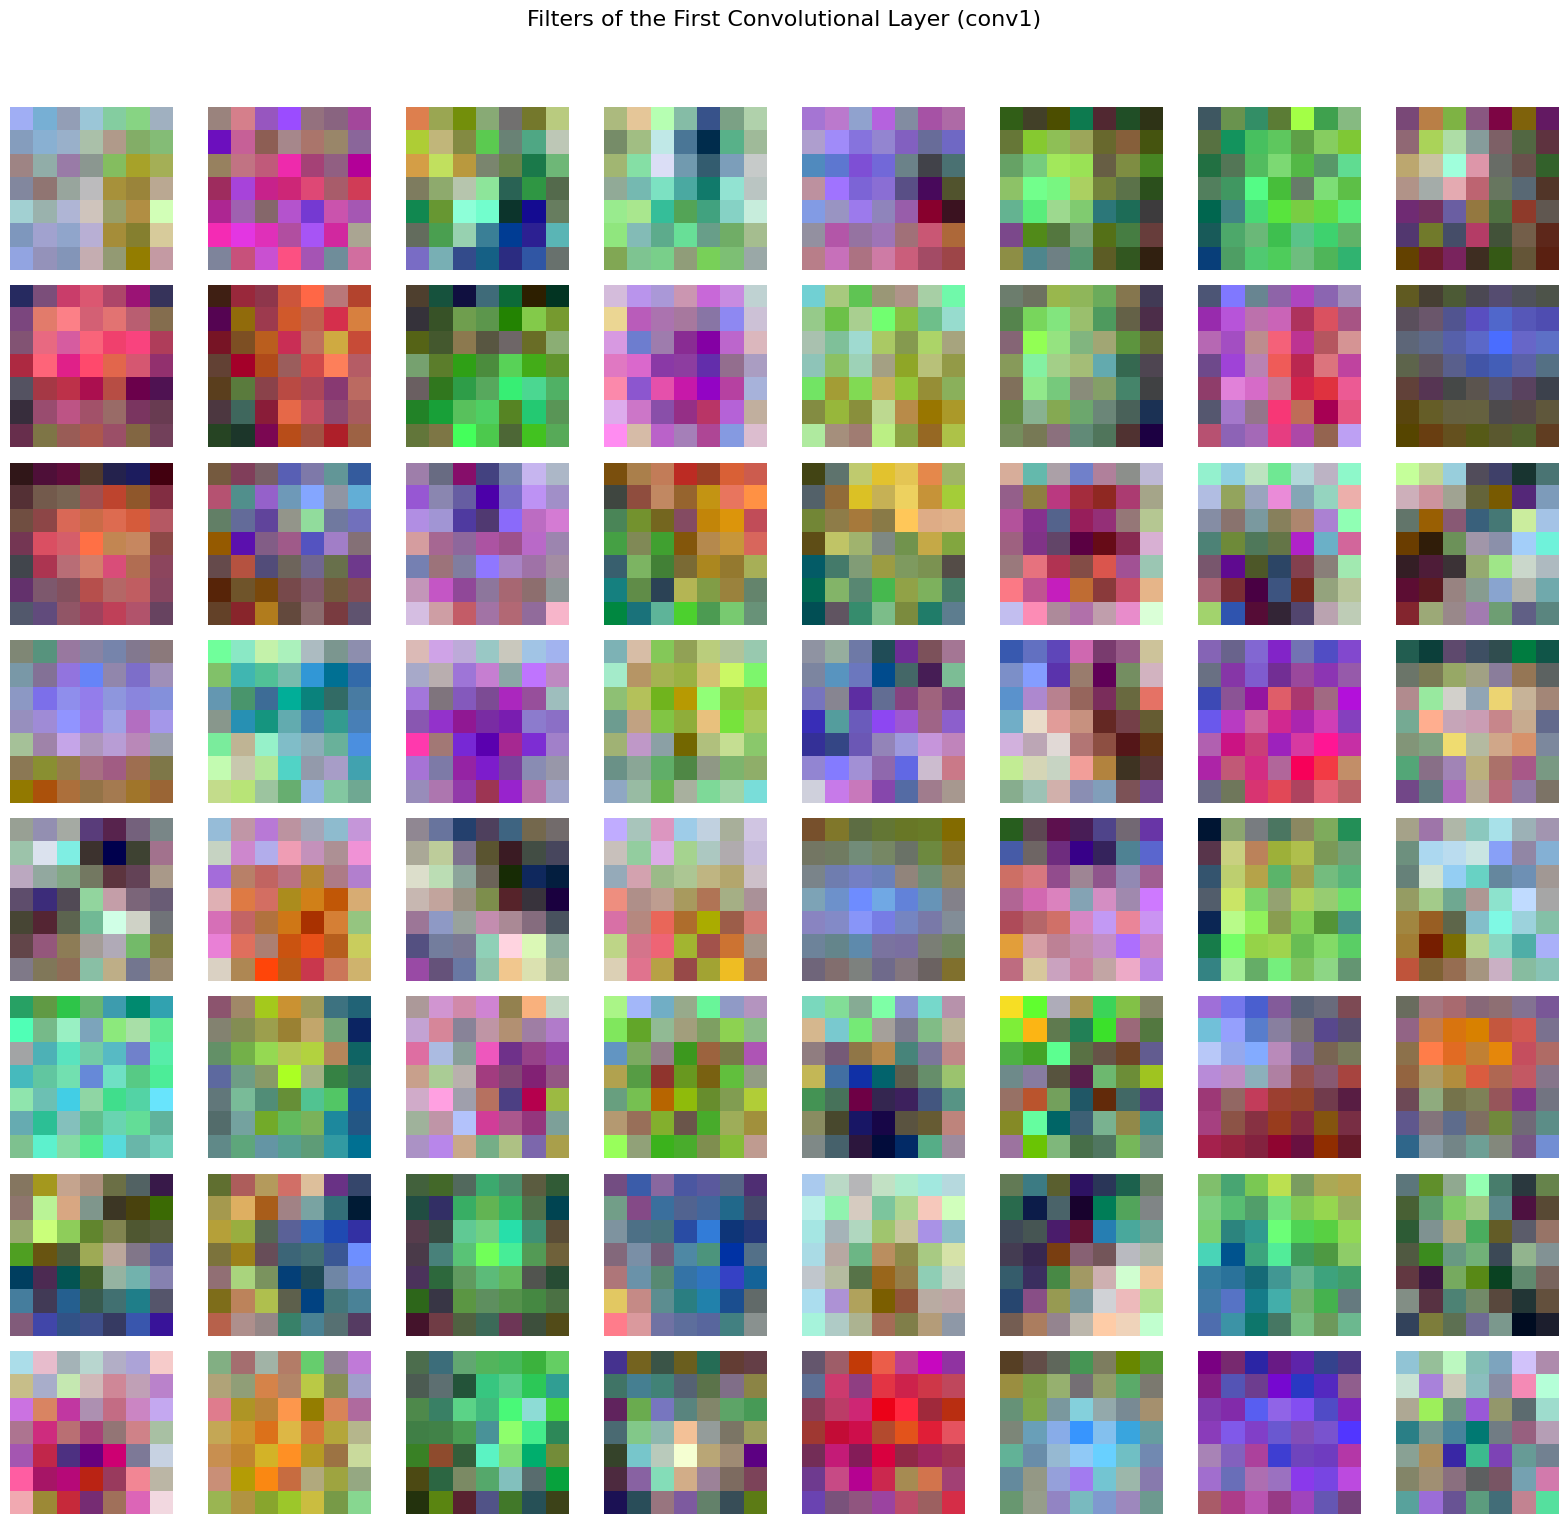

CustomResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 6

In [14]:
# Model's Filter Visualization
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn

model_cpu = model.to('cpu')

filters = model_cpu.conv1.weight.data.clone()

num_filters = filters.shape[0]

normalized_filters = torch.zeros_like(filters)
for i in range(num_filters):
    f = filters[i]
    f_min = f.min()
    f_max = f.max()
    if f_max - f_min > 0:
        normalized_filters[i] = (f - f_min) / (f_max - f_min)
    else:
        normalized_filters[i] = f - f_min

rows = int(np.ceil(np.sqrt(num_filters)))
cols = int(np.ceil(num_filters / rows))

plt.figure(figsize=(cols*2, rows*2))

for i in range(num_filters):
    plt.subplot(rows, cols, i + 1)

    filter_to_show = normalized_filters[i].permute(1, 2, 0).numpy()
    plt.imshow(filter_to_show)
    plt.axis('off')

plt.suptitle('Filters of the First Convolutional Layer (conv1)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

model.to(device)
